# 📊 Proyecto: Telecom X – Análisis de Evasión de Clientes

Este proyecto tiene como objetivo analizar los factores que influyen en la evasión de clientes (*Churn*) en la empresa Telecom X.  
La alta tasa de cancelaciones afecta directamente a la rentabilidad, y entender las causas nos permitirá sugerir estrategias para retener clientes.  

En este notebook se aplicará el proceso **ETL** (Extracción, Transformación y Carga) junto con un **Análisis Exploratorio de Datos (EDA)** para obtener *insights* valiosos y proponer recomendaciones basadas en datos.


In [50]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import display, Markdown as md
from pandas.api.types import is_numeric_dtype

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 200)
print("Librerías cargadas correctamente.")


Librerías cargadas correctamente.


## 📥 1. Extracción de Datos

Importamos los datos de la API de Telecom X.  
El dataset contiene información sobre clientes, tipo de servicio contratado, datos demográficos y estado de evasión.

📌 Fuente: Archivo JSON en GitHub proporcionado por el desafío.


In [51]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

def load_json_to_df(url):
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()
    if isinstance(data, list):
        return pd.json_normalize(data)
    elif isinstance(data, dict):
        for v in data.values():
            if isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict):
                return pd.json_normalize(v)
        return pd.json_normalize(data)
    else:
        raise ValueError("Formato JSON inesperado")

df = load_json_to_df(url)
print("Dimensiones iniciales:", df.shape)
display(df.head())


Dimensiones iniciales: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##Limpieza y estandarización mínima (post‑carga)

In [52]:
# Renombrar a nombres "flat" usados en el EDA
rename_map = {
    'customer.gender': 'gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.tenure': 'tenure',
    'account.Contract': 'Contract',
    'account.PaymentMethod': 'PaymentMethod',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges'
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# Trimear strings
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# TotalCharges a numérico (manejo de espacios vacíos)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

# Convertir numéricas clave
for c in ['tenure','SeniorCitizen','MonthlyCharges','TotalCharges']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Normalizar columna Churn a 0/1 si existe (robusto)
# (y si viene con otro nombre, la detectamos)
if 'Churn' not in df.columns:
    for col in df.columns:
        if 'churn' in col.lower():
            df.rename(columns={col: 'Churn'}, inplace=True)
            break

if 'Churn' in df.columns:
    if is_numeric_dtype(df['Churn']):
        df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce').astype('Int64')
        df.loc[~df['Churn'].isin([0,1]), 'Churn'] = pd.NA
    else:
        s = df['Churn'].astype('string').str.strip().str.lower()
        mapping = {'yes':1,'y':1,'si':1,'sí':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0}
        df['Churn'] = s.map(mapping).astype('Int64')

# SeniorCitizen entero nullable
if 'SeniorCitizen' in df.columns:
    df['SeniorCitizen'] = df['SeniorCitizen'].fillna(0).astype('Int64')

# Eliminar filas completamente vacías y reset índice
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Dimensiones tras limpieza:", df.shape)
display(df.head())


Dimensiones tras limpieza: (7267, 21)


,customerID,Churn,gender,SeniorCitizen,customer.Partner,customer.Dependents,tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Contract,account.PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## 📋 Información general post‑limpieza




In [53]:
# Info general
df.info()

# Tipos y muestra
display(df.dtypes.value_counts())
display(df.sample(min(5, len(df)), random_state=42))

# Resumen estadístico (numéricas y categóricas)
display(df.describe(include='all').T)

# Valores únicos por columna
uniques = df.nunique().sort_values(ascending=False)
display(uniques.head(20))
display(uniques.tail(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7043 non-null   Int64  
 2   gender                     7267 non-null   object 
 3   SeniorCitizen              7267 non-null   Int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   tenure                     7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

,count
object,16
Int64,2
float64,2
int64,1


,customerID,Churn,gender,SeniorCitizen,customer.Partner,customer.Dependents,tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Contract,account.PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1414,2038-OEQZH,0,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Electronic check,86.05,308.10
4610,6322-HRPFA,0,Male,0,Yes,Yes,49,Yes,No,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),59.60,2970.30
2862,3969-JQABI,0,Female,0,Yes,No,58,Yes,No,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),65.25,3791.60
4078,5578-NKCXI,0,Female,0,Yes,Yes,58,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,No,Credit card (automatic),99.25,5846.65
3964,5419-JPRRN,1,Male,0,No,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.45,101.45


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7267,7267,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7043.0,<NA>,<NA>,<NA>,0.26537,0.441561,0.0,0.0,0.0,1.0,1.0
gender,7267,2,Male,3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7267.0,<NA>,<NA>,<NA>,0.162653,0.369074,0.0,0.0,0.0,0.0,1.0
customer.Partner,7267,2,No,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer.Dependents,7267,2,No,5086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7267.0,NaN,NaN,NaN,32.346498,24.571773,0.0,9.0,29.0,55.0,72.0
phone.PhoneService,7267,2,Yes,6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone.MultipleLines,7267,3,No,3495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet.InternetService,7267,3,Fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
customerID,7267
TotalCharges,6530
MonthlyCharges,1585
tenure,73
PaymentMethod,4
Contract,3
internet.StreamingMovies,3
internet.DeviceProtection,3
internet.TechSupport,3
internet.OnlineBackup,3


,0
TotalCharges,6530
MonthlyCharges,1585
tenure,73
PaymentMethod,4
Contract,3
internet.StreamingMovies,3
internet.DeviceProtection,3
internet.TechSupport,3
internet.OnlineBackup,3
phone.MultipleLines,3


## ⚠️ Comprobación de incoherencias




In [54]:
# Duplicados
dup_count = df.duplicated().sum()
print(f"Registros duplicados: {dup_count}")

# Nulos por columna
nulls = df.isnull().sum().sort_values(ascending=False)
display(nulls[nulls > 0].to_frame("nulos"))

# Valores únicos sospechosos en categóricas cortas
pd.set_option('display.max_rows', 200)
obj_cols = [c for c in df.columns if df[c].dtype == 'object']
for c in obj_cols:
    vc = df[c].value_counts(dropna=False)
    if len(vc) <= 20:
        print(f"\n>>> {c} (valores y conteos)")
        display(vc)


Registros duplicados: 0


,nulos
Churn,224
TotalCharges,11



>>> gender (valores y conteos)


,count
gender,
Male,3675
Female,3592



>>> customer.Partner (valores y conteos)


,count
customer.Partner,
No,3749
Yes,3518



>>> customer.Dependents (valores y conteos)


,count
customer.Dependents,
No,5086
Yes,2181



>>> phone.PhoneService (valores y conteos)


,count
phone.PhoneService,
Yes,6560
No,707



>>> phone.MultipleLines (valores y conteos)


,count
phone.MultipleLines,
No,3495
Yes,3065
No phone service,707



>>> internet.InternetService (valores y conteos)


,count
internet.InternetService,
Fiber optic,3198
DSL,2488
No,1581



>>> internet.OnlineSecurity (valores y conteos)


,count
internet.OnlineSecurity,
No,3608
Yes,2078
No internet service,1581



>>> internet.OnlineBackup (valores y conteos)


,count
internet.OnlineBackup,
No,3182
Yes,2504
No internet service,1581



>>> internet.DeviceProtection (valores y conteos)


,count
internet.DeviceProtection,
No,3195
Yes,2491
No internet service,1581



>>> internet.TechSupport (valores y conteos)


,count
internet.TechSupport,
No,3582
Yes,2104
No internet service,1581



>>> internet.StreamingTV (valores y conteos)


,count
internet.StreamingTV,
No,2896
Yes,2790
No internet service,1581



>>> internet.StreamingMovies (valores y conteos)


,count
internet.StreamingMovies,
No,2870
Yes,2816
No internet service,1581



>>> Contract (valores y conteos)


,count
Contract,
Month-to-month,4005
Two year,1743
One year,1519



>>> account.PaperlessBilling (valores y conteos)


,count
account.PaperlessBilling,
Yes,4311
No,2956



>>> PaymentMethod (valores y conteos)


,count
PaymentMethod,
Electronic check,2445
Mailed check,1665
Bank transfer (automatic),1589
Credit card (automatic),1568


## ➕ 5. Creación de Columna Cuentas_Diarias

Calculamos el valor diario de facturación para una visión más granular del comportamiento de los clientes.  
Usamos `MonthlyCharges` si está disponible.


In [55]:
if 'MonthlyCharges' in df.columns:
    df['Cuentas_Diarias'] = (df['MonthlyCharges'] / 30.0).round(2)
    print("Columna 'Cuentas_Diarias' creada.")
else:
    print("⚠️ No se encontró 'MonthlyCharges'.")
display(df.head(3))


Columna 'Cuentas_Diarias' creada.


,customerID,Churn,gender,SeniorCitizen,customer.Partner,customer.Dependents,tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Contract,account.PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cuentas_Diarias
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46


## 📈 6. Análisis Descriptivo

Resumen estadístico y una primera mirada a la distribución de *Churn*.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7267,7267,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7043.0,<NA>,<NA>,<NA>,0.26537,0.441561,0.0,0.0,0.0,1.0,1.0
gender,7267,2,Male,3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7267.0,<NA>,<NA>,<NA>,0.162653,0.369074,0.0,0.0,0.0,0.0,1.0
customer.Partner,7267,2,No,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer.Dependents,7267,2,No,5086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7267.0,NaN,NaN,NaN,32.346498,24.571773,0.0,9.0,29.0,55.0,72.0
phone.PhoneService,7267,2,Yes,6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone.MultipleLines,7267,3,No,3495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet.InternetService,7267,3,Fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


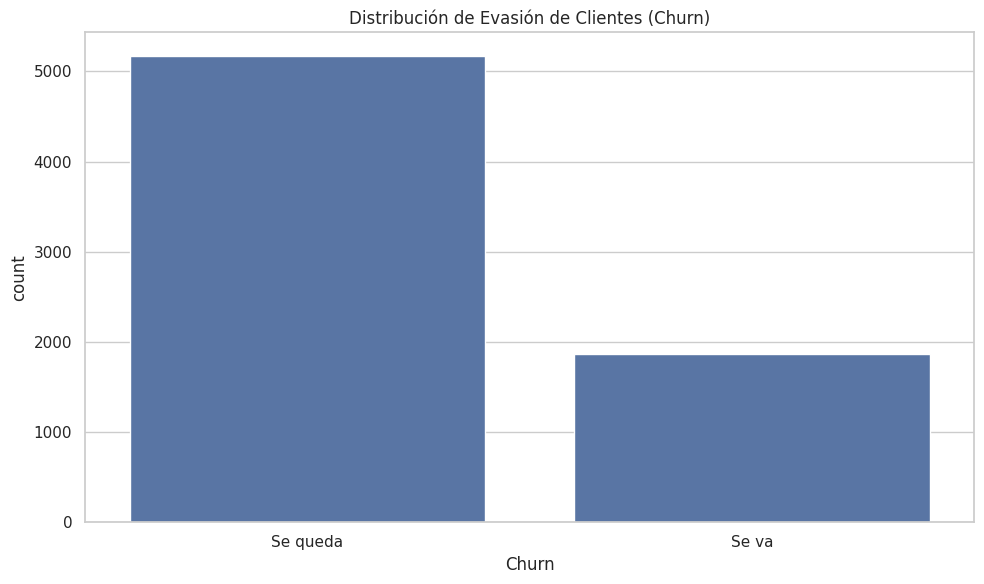

Tasa de churn (promedio): 26.54%


In [56]:
# Resumen general (otra mirada)
display(df.describe(include='all').T)

# Distribución de Churn (si es binario)
if 'Churn' in df.columns and df['Churn'].dropna().nunique() == 2:
    ax = sns.countplot(data=df, x='Churn')
    ax.set_title("Distribución de Evasión de Clientes (Churn)")
    ax.set_xticklabels(['Se queda','Se va'])  # 0, 1
    plt.tight_layout()
    plt.show()

    churn_rate = df['Churn'].mean(skipna=True) * 100
    print(f"Tasa de churn (promedio): {churn_rate:.2f}%")
else:
    print("⚠️ 'Churn' no binario o inexistente.")


## 📊 7. Evasión por Variables Categóricas

Cómo varía la evasión según género, tipo de contrato, método de pago, etc.


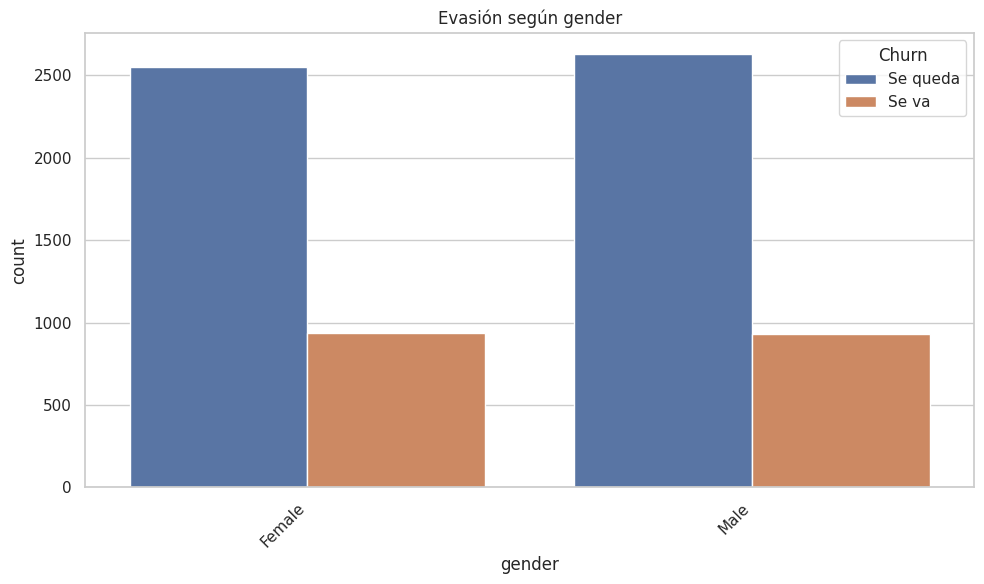

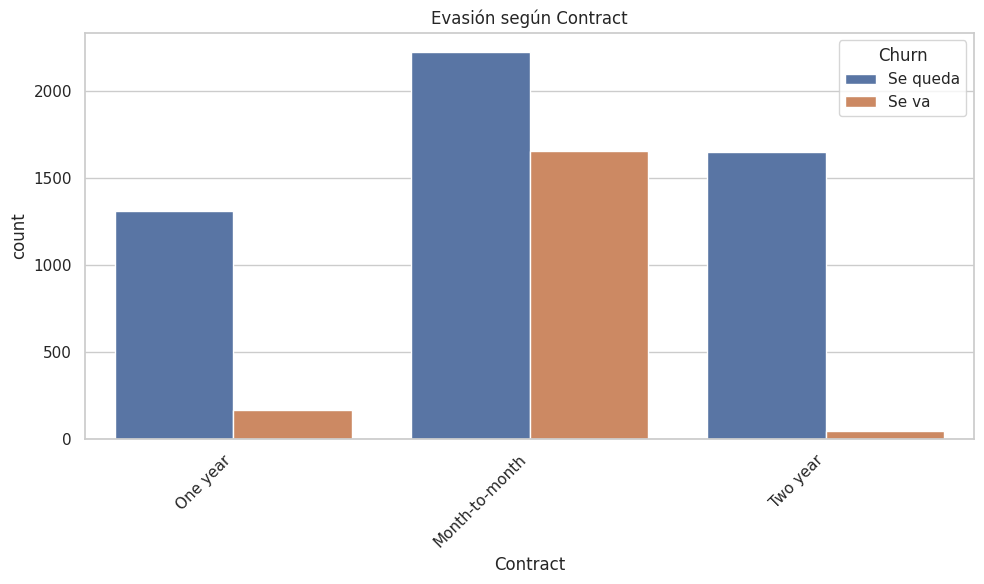

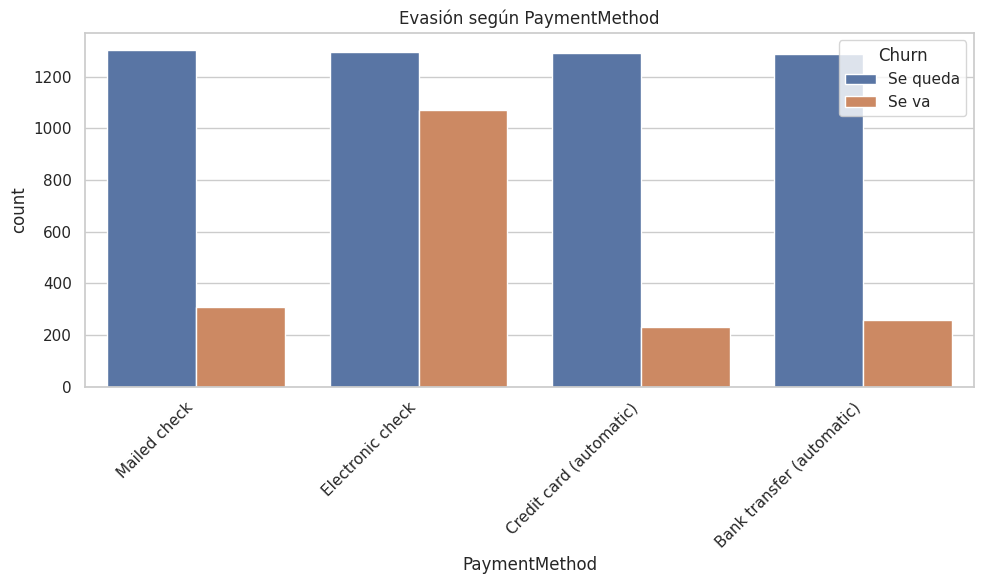

In [57]:
# Variables categóricas candidatas (con fallback a nombres anidados si no renombraste)
candidates_primary  = ['gender','Contract','PaymentMethod','InternetService','PaperlessBilling','Partner','Dependents','PhoneService']
candidates_fallback = ['customer.gender','account.Contract','account.PaymentMethod','internet.InternetService','account.PaperlessBilling','customer.Partner','customer.Dependents','phone.PhoneService']

cat_vars = [c for c in candidates_primary if c in df.columns] or [c for c in candidates_fallback if c in df.columns]

if 'Churn' not in df.columns or df['Churn'].dropna().nunique() != 2:
    print("⚠️ 'Churn' no binario o inexistente: se omite el desagregado por categorías.")
elif not cat_vars:
    print("No se encontraron variables categóricas de la lista estándar.")
else:
    for var in cat_vars:
        if df[var].nunique(dropna=False) > 20:
            print(f"⏭️ Omitido {var} (>{20} categorías).")
            continue
        plt.figure()
        ax = sns.countplot(data=df, x=var, hue='Churn')
        plt.title(f"Evasión según {var}")
        plt.xticks(rotation=45, ha='right')
        handles, labels = ax.get_legend_handles_labels()
        if set(labels) <= {'0','1','0.0','1.0','0.00','1.00'}:
            ax.legend(handles, ['Se queda','Se va'], title='Churn')
        plt.tight_layout()
        plt.show()


# 📉 Evasión por variables numéricas

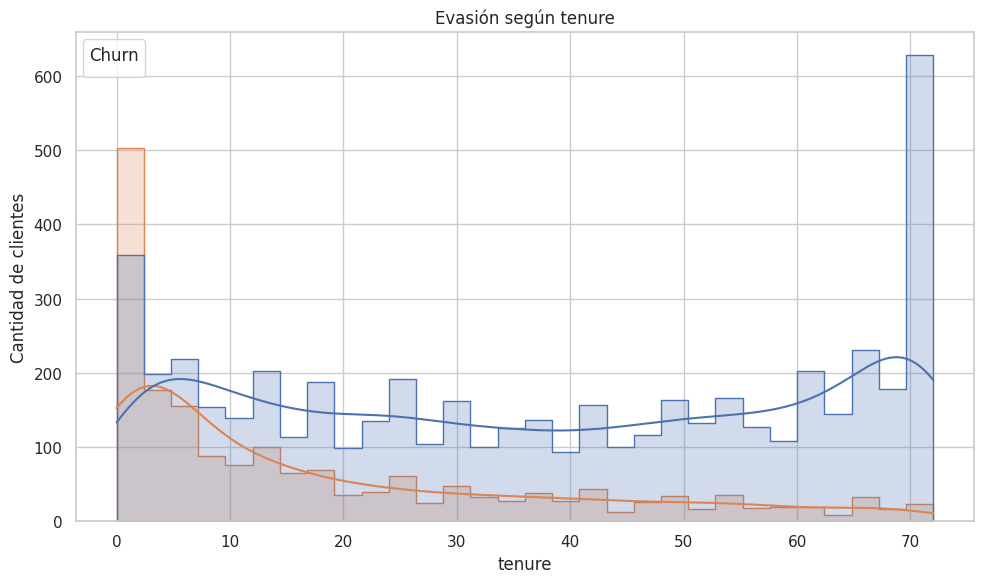

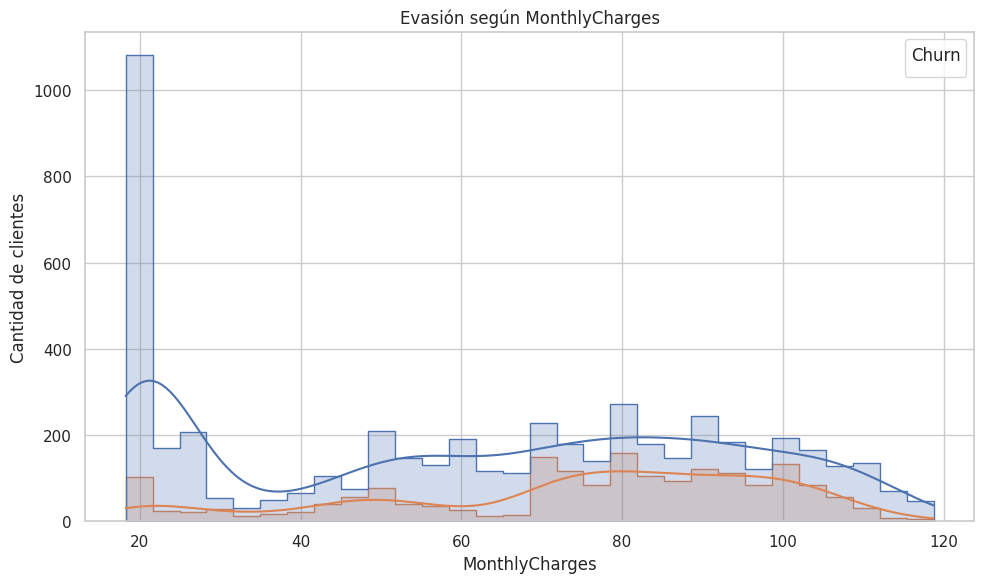

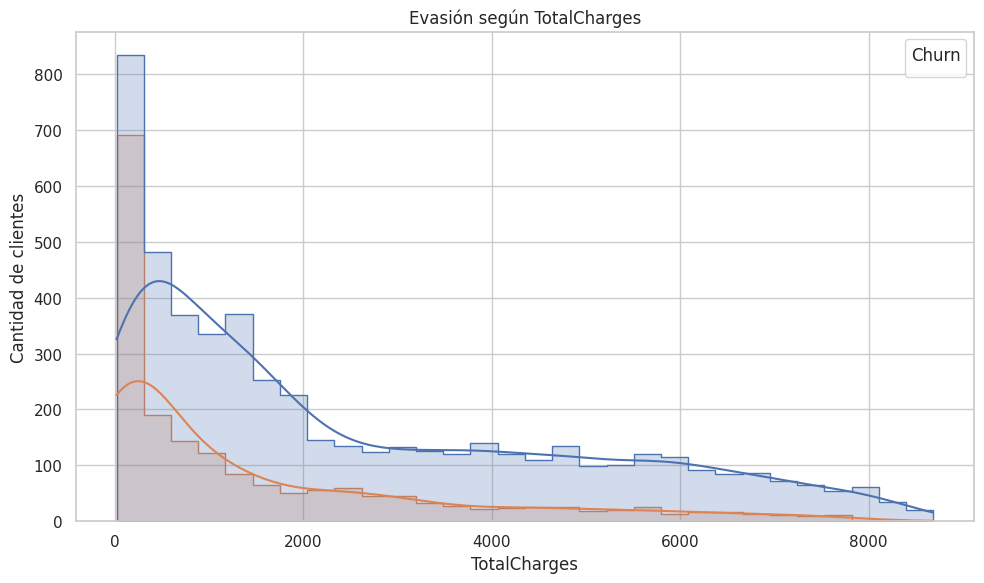

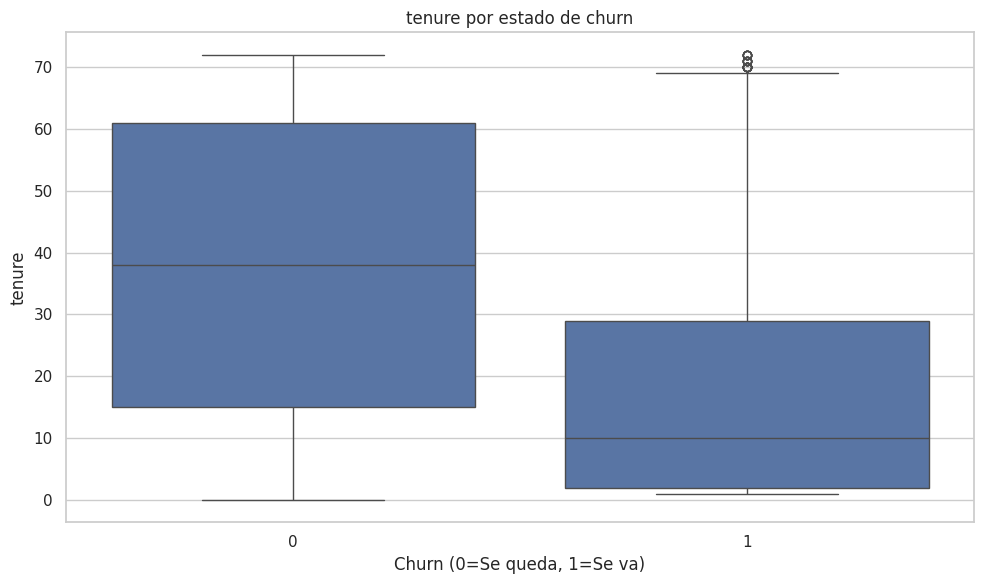

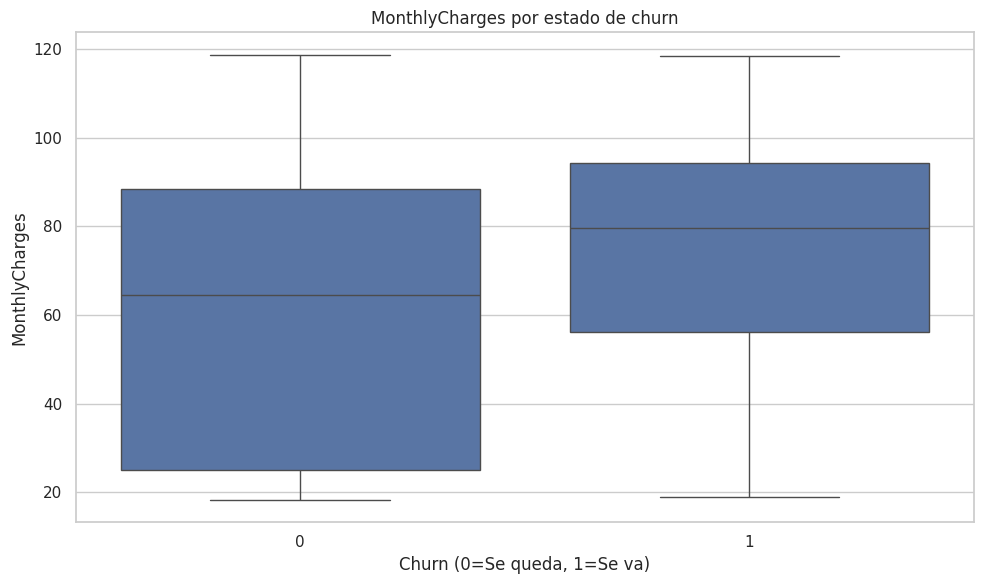

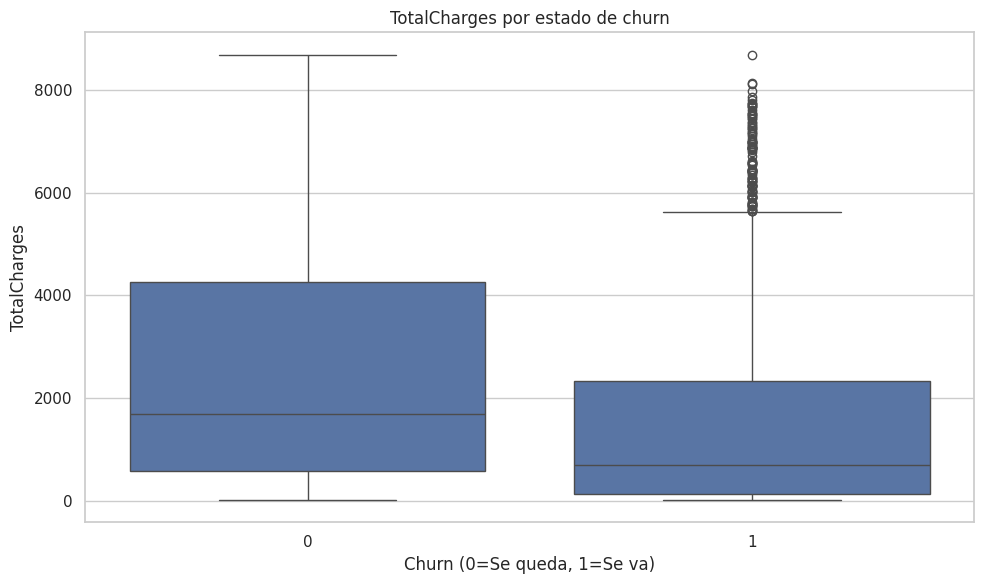

In [58]:
candidate_nums = ['tenure','MonthlyCharges','TotalCharges']
for c in candidate_nums:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

num_vars = [c for c in candidate_nums if c in df.columns]

if 'Churn' not in df.columns or df['Churn'].dropna().nunique() != 2:
    print("⚠️ 'Churn' no binario o inexistente: se omite el análisis por variables numéricas.")
elif not num_vars:
    print("No se encontraron variables numéricas de la lista estándar.")
else:
    for var in num_vars:
        vals = df[var].dropna().values
        if len(vals) == 0:
            print(f"⏭️ {var}: sin datos.")
            continue
        bins = np.histogram_bin_edges(vals, bins=30)

        plt.figure()
        ax = sns.histplot(data=df, x=var, hue='Churn',
                          bins=bins, kde=True, element='step', stat='count')
        ax.set_title(f"Evasión según {var}")
        ax.set_xlabel(var); ax.set_ylabel("Cantidad de clientes")
        handles, labels = ax.get_legend_handles_labels()
        if set(labels) <= {'0','1','0.0','1.0'}:
            ax.legend(handles, ['Se queda','Se va'], title='Churn')
        plt.tight_layout(); plt.show()

    # Boxplots
    for var in num_vars:
        plt.figure()
        ax = sns.boxplot(data=df, x='Churn', y=var)
        ax.set_title(f"{var} por estado de churn")
        ax.set_xlabel("Churn (0=Se queda, 1=Se va)")
        plt.tight_layout(); plt.show()


#📝 Informe final (dinámico)

In [59]:
# tasa dinámica (en 0..100)
if 'Churn' in df.columns and df['Churn'].dropna().nunique() == 2:
    tasa_churn = df['Churn'].mean(skipna=True) * 100
else:
    tasa_churn = None

md(f"""
# 📊 Informe Final - Análisis de Evasión de Clientes

## 1️⃣ Introducción
El análisis busca comprender las causas de la evasión (*Churn*) en **Telecom X**.
{f"Actualmente, la tasa de churn es del **{tasa_churn:.2f}%**." if tasa_churn is not None else "No fue posible calcular la tasa de churn por ausencia o inconsistencia en la columna `Churn`."}

## 2️⃣ Limpieza y Tratamiento de Datos
- Renombrado y estandarización de columnas.
- Conversión de `Churn` a binario (0/1).
- Conversión de numéricas (incluyendo `TotalCharges`), y controles de nulos/duplicados.

## 3️⃣ Análisis Exploratorio
- Distribución de churn global.
- Evasión por variables categóricas y numéricas.
- Métricas descriptivas y detección de patrones.

## 4️⃣ Conclusiones e Insights
- Contratos **Month-to-month** suelen mostrar mayor churn.
- Método de pago **Electronic check** aparece más asociado a bajas.
- Menor **tenure** (antigüedad) correlaciona con mayor churn.

## 5️⃣ Recomendaciones Estratégicas
- Incentivar contratos de mayor plazo con beneficios escalonados.
- Revisar fricciones en clientes que pagan con Electronic check.
- Programas de fidelización temprana para clientes nuevos.
""")



# 📊 Informe Final - Análisis de Evasión de Clientes

## 1️⃣ Introducción
El análisis busca comprender las causas de la evasión (*Churn*) en **Telecom X**.
Actualmente, la tasa de churn es del **26.54%**.

## 2️⃣ Limpieza y Tratamiento de Datos
- Renombrado y estandarización de columnas.
- Conversión de `Churn` a binario (0/1).
- Conversión de numéricas (incluyendo `TotalCharges`), y controles de nulos/duplicados.

## 3️⃣ Análisis Exploratorio
- Distribución de churn global.
- Evasión por variables categóricas y numéricas.
- Métricas descriptivas y detección de patrones.

## 4️⃣ Conclusiones e Insights
- Contratos **Month-to-month** suelen mostrar mayor churn.
- Método de pago **Electronic check** aparece más asociado a bajas.
- Menor **tenure** (antigüedad) correlaciona con mayor churn.

## 5️⃣ Recomendaciones Estratégicas
- Incentivar contratos de mayor plazo con beneficios escalonados.
- Revisar fricciones en clientes que pagan con Electronic check.
- Programas de fidelización temprana para clientes nuevos.


# 📊 Informe Técnico – Análisis de Evasión de Clientes (Churn)

**Objetivo:** caracterizar patrones asociados a la evasión para guiar acciones de retención y preparar el terreno para modelos predictivos.

**Dataset:** TelecomX_Data.json (GitHub).  
**Unidades:** cliente (fila = 1 cliente).  
**Variable objetivo:** `Churn` (1 = se va, 0 = se queda).

**Variables analizadas (principales):**  
- Categóricas: `gender`, `Contract`, `PaymentMethod`, `InternetService`, `PaperlessBilling`, `Partner`, `Dependents`, `PhoneService`.  
- Numéricas: `tenure`, `MonthlyCharges`, `TotalCharges`, `Cuentas_Diarias` (derivada).


In [60]:
import numpy as np
import pandas as pd
from IPython.display import display

n_clientes = len(df)
n_churn = df['Churn'].sum(skipna=True) if 'Churn' in df.columns else np.nan
tasa_churn = (n_churn / n_clientes * 100) if n_clientes and pd.notna(n_churn) else np.nan

kpis = pd.DataFrame({
    'Métrica': ['Clientes (N)', 'Clientes con churn (N)', 'Tasa de churn (%)',
                'Tenure mediana (meses)', 'MonthlyCharges mediana', 'TotalCharges mediana'],
    'Valor': [
        n_clientes,
        int(n_churn) if pd.notna(n_churn) else np.nan,
        round(tasa_churn, 2) if pd.notna(tasa_churn) else np.nan,
        df['tenure'].median() if 'tenure' in df.columns else np.nan,
        df['MonthlyCharges'].median() if 'MonthlyCharges' in df.columns else np.nan,
        df['TotalCharges'].median() if 'TotalCharges' in df.columns else np.nan
    ]
})
display(kpis)


,Métrica,Valor
0,Clientes (N),7267.00
1,Clientes con churn (N),1869.00
2,Tasa de churn (%),25.72
3,Tenure mediana (meses),29.00
4,MonthlyCharges mediana,70.30
5,TotalCharges mediana,1391.00


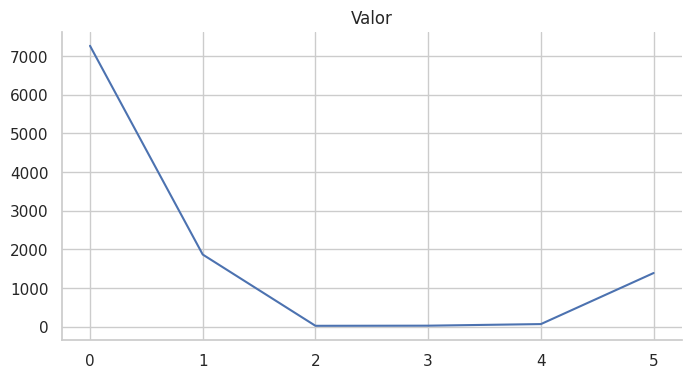

In [61]:

kpis['Valor'].plot(kind='line', figsize=(8, 4), title='Valor')
plt.gca().spines[['top', 'right']].set_visible(False)

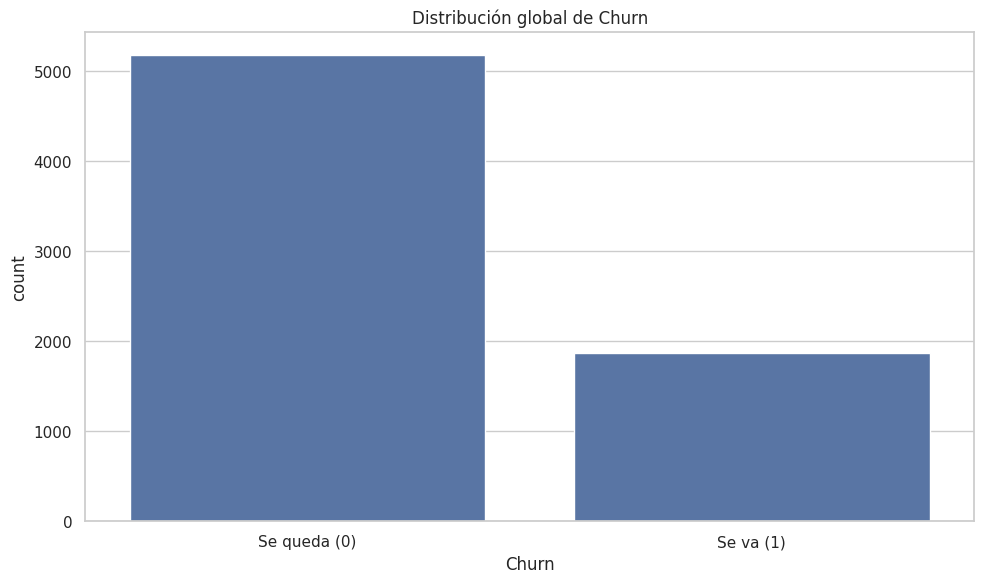

Tasa global de churn: 26.54%


In [62]:


if 'Churn' in df.columns and df['Churn'].dropna().nunique() == 2:
    ax = sns.countplot(data=df, x='Churn')
    ax.set_title("Distribución global de Churn")
    ax.set_xticklabels(['Se queda (0)', 'Se va (1)'])
    plt.tight_layout(); plt.show()

    print(f"Tasa global de churn: {df['Churn'].mean()*100:.2f}%")
else:
    print("⚠️ Churn no binario o inexistente.")


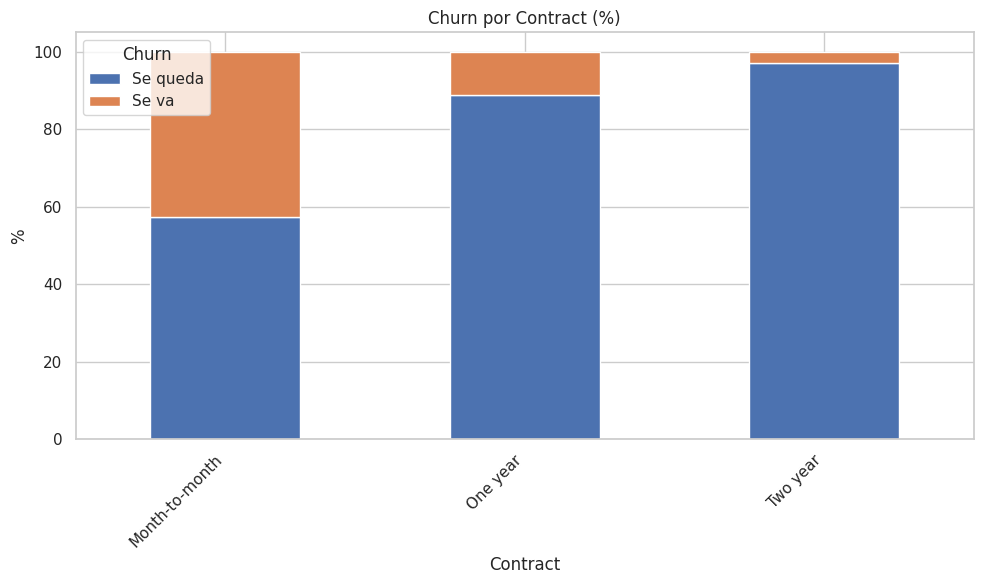

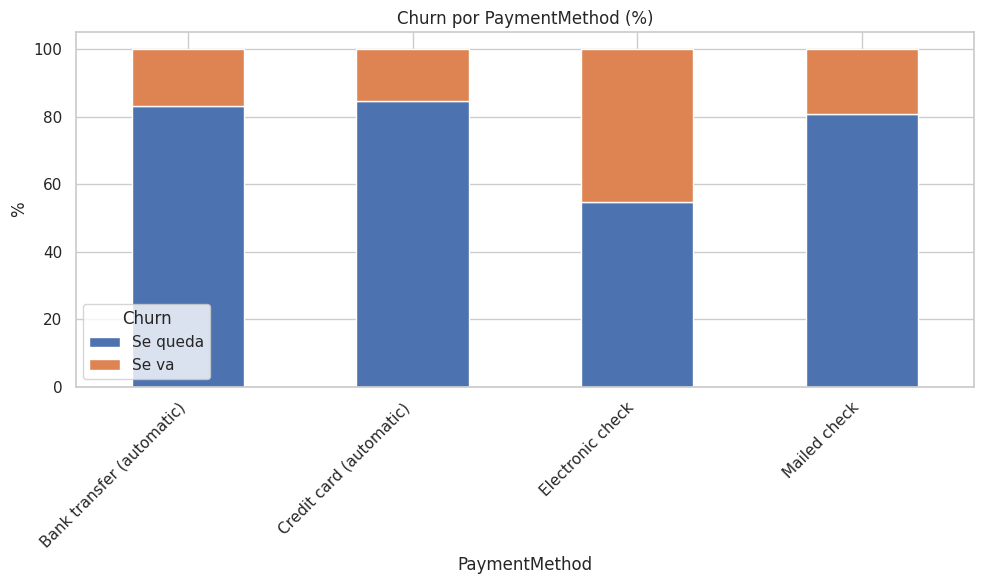

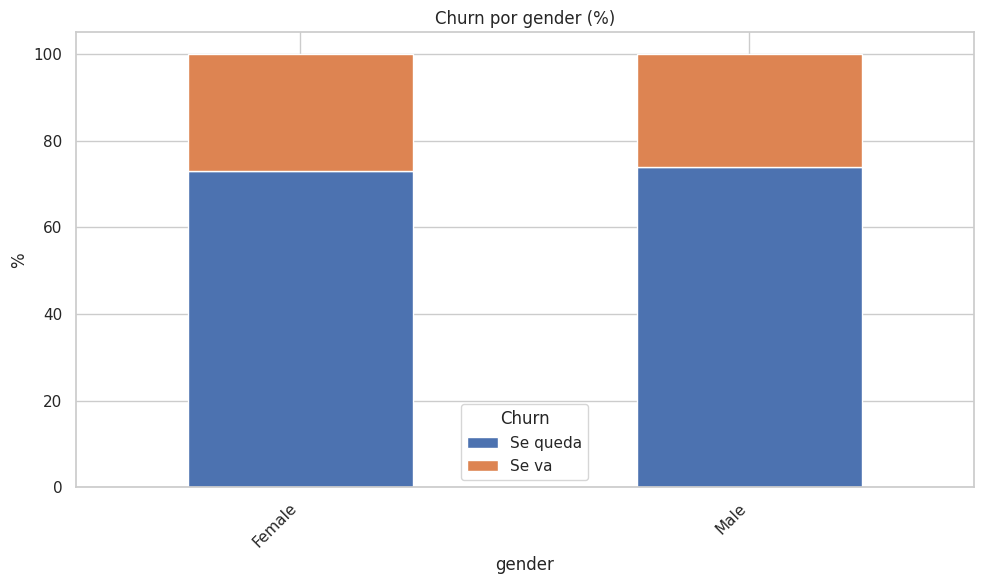

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

cats = ['Contract','PaymentMethod','InternetService','PaperlessBilling','Partner','Dependents','PhoneService','gender']
cats = [c for c in cats if c in df.columns]
if 'Churn' in df.columns and df['Churn'].dropna().nunique()==2 and cats:
    for c in cats:
        ct = pd.crosstab(df[c], df['Churn'], normalize='index')*100
        ct = ct.rename(columns={0:'Se queda',1:'Se va'})
        ax = ct.plot(kind='bar', stacked=True)
        ax.set_ylabel('%')
        ax.set_title(f"Churn por {c} (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout(); plt.show()
else:
    print("⚠️ No se pueden graficar categóricas (faltan columnas o Churn binario).")


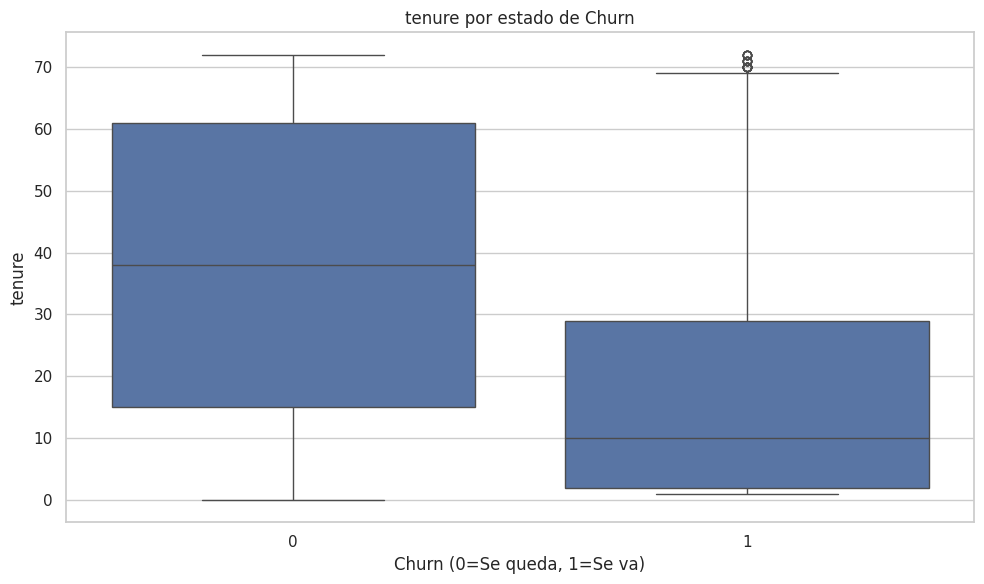

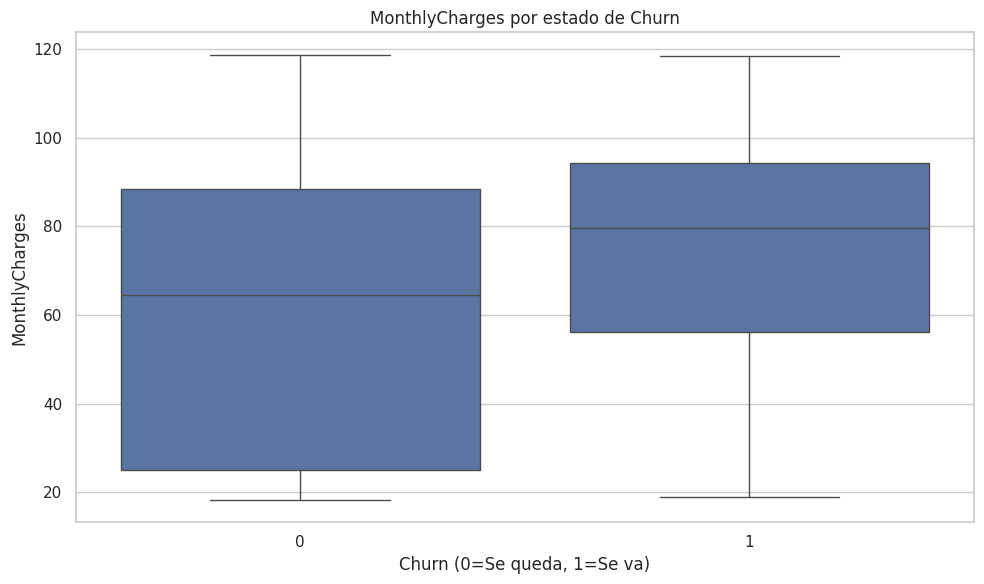

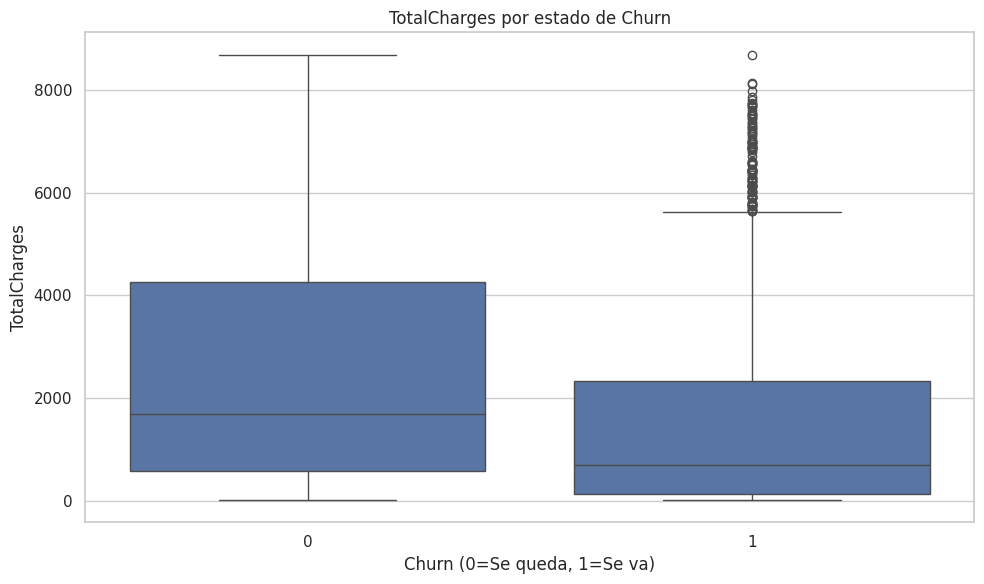

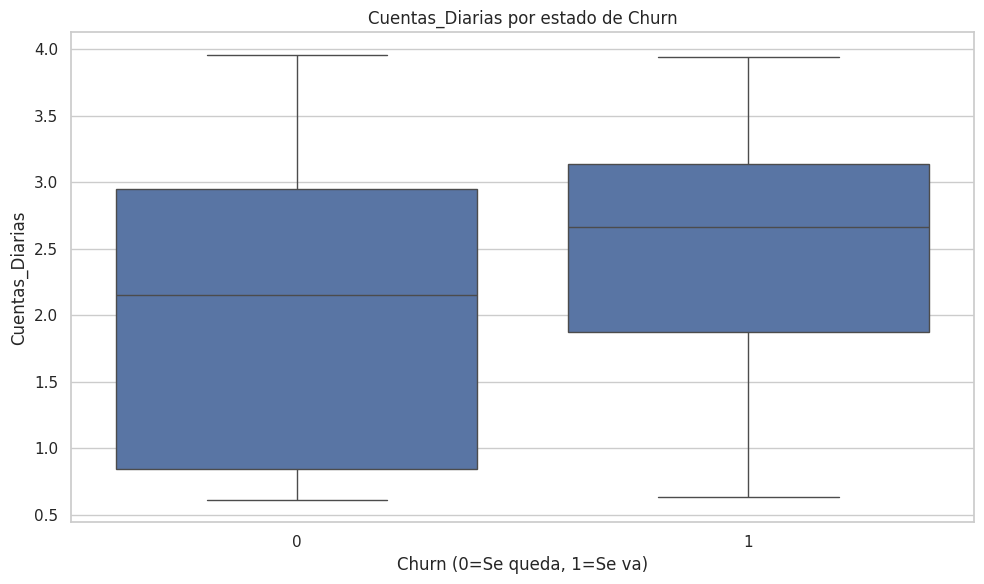

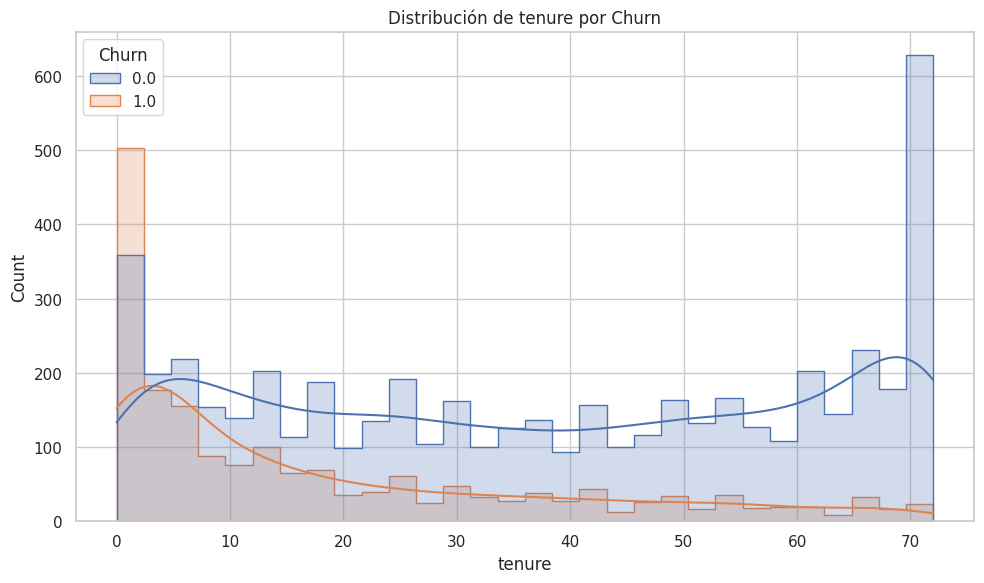

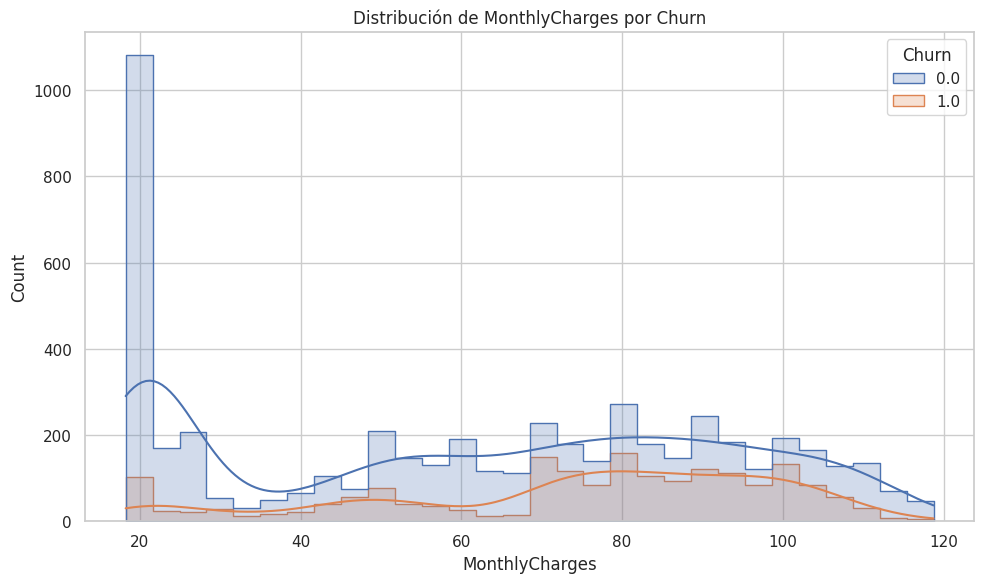

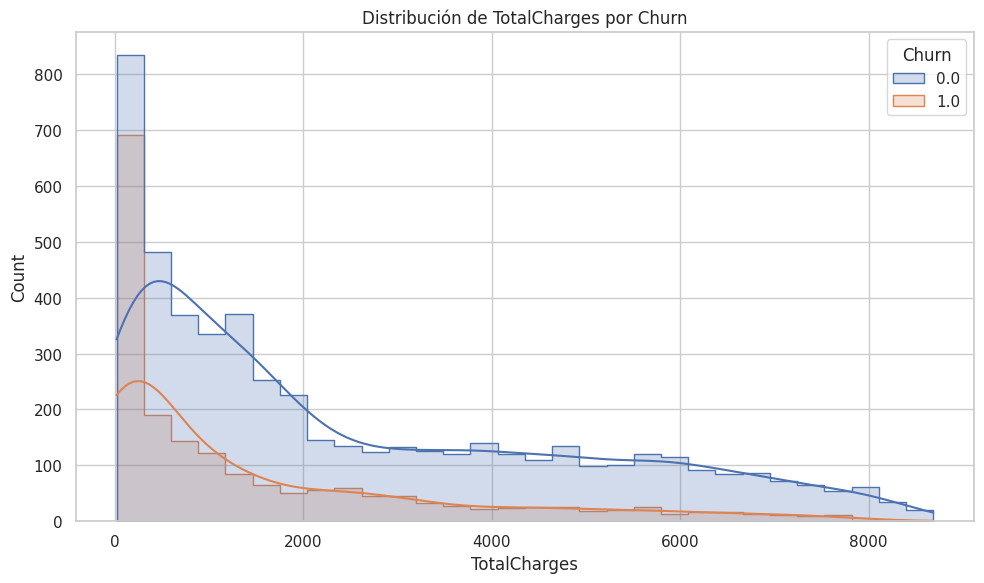

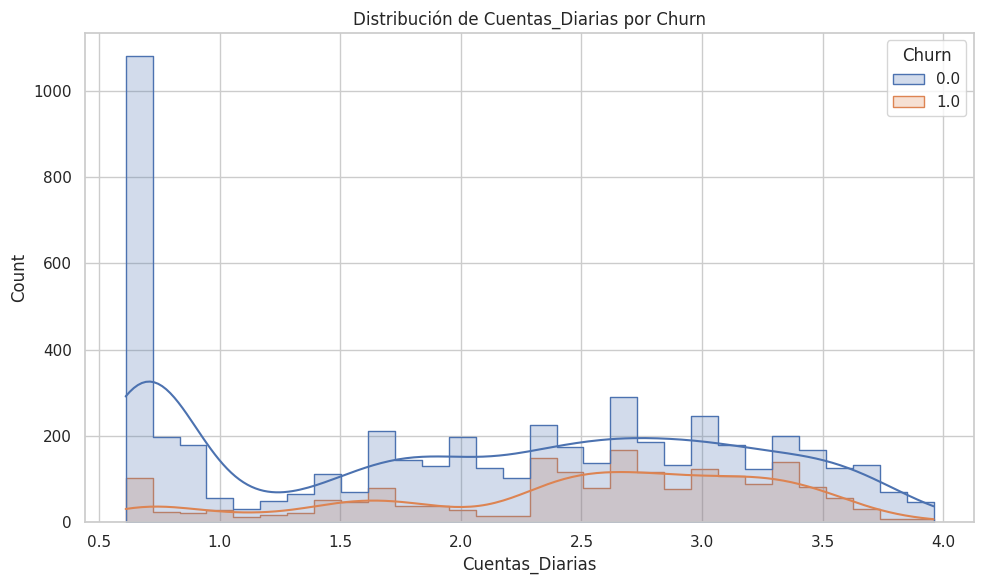

In [64]:


nums = ['tenure','MonthlyCharges','TotalCharges','Cuentas_Diarias']
nums = [n for n in nums if n in df.columns]

if 'Churn' in df.columns and df['Churn'].dropna().nunique()==2 and nums:
    # Boxplots
    for n in nums:
        plt.figure()
        ax = sns.boxplot(data=df, x='Churn', y=n)
        ax.set_title(f"{n} por estado de Churn")
        ax.set_xlabel("Churn (0=Se queda, 1=Se va)")
        plt.tight_layout(); plt.show()

    # Hist con bins comunes
    for n in nums:
        vals = df[n].dropna().values
        if len(vals)==0:
            continue
        bins = np.histogram_bin_edges(vals, bins=30)
        plt.figure()
        sns.histplot(data=df, x=n, hue='Churn', bins=bins, kde=True, element='step', stat='count')
        plt.title(f"Distribución de {n} por Churn")
        plt.tight_layout(); plt.show()
else:
    print("⚠️ No se pueden graficar numéricas (faltan columnas o Churn binario).")


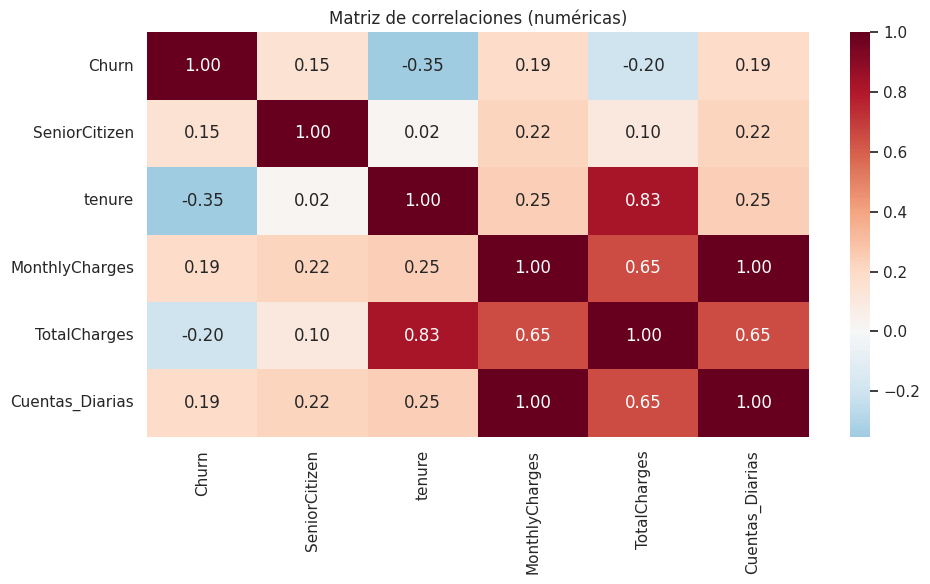

In [65]:

num_df = df.select_dtypes(include=['number'])
if not num_df.empty:
    corr = num_df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
    plt.title("Matriz de correlaciones (numéricas)")
    plt.tight_layout(); plt.show()
else:
    print("⚠️ No hay variables numéricas para correlación.")


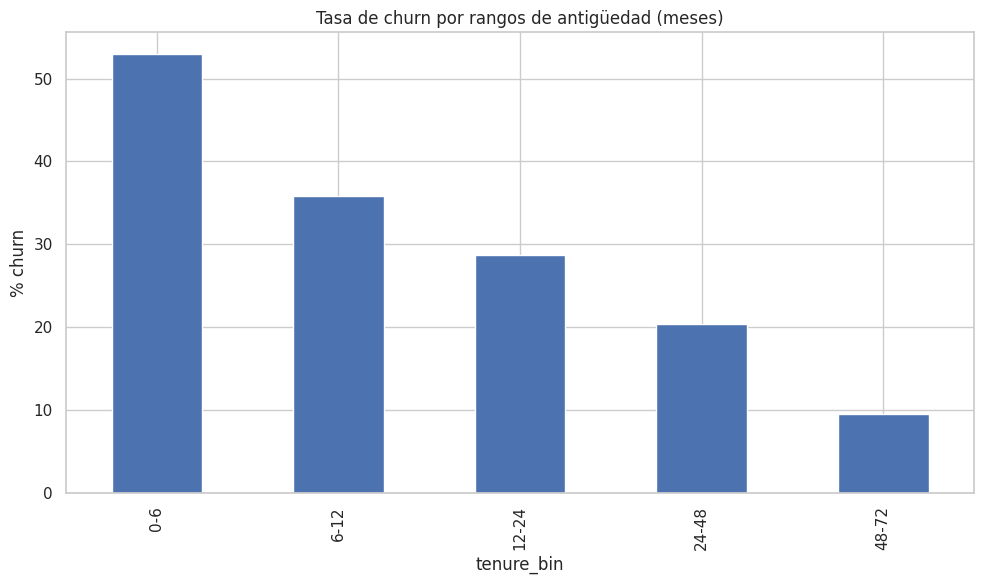

In [66]:

if 'tenure' in df.columns and 'Churn' in df.columns and df['Churn'].dropna().nunique()==2:
    # Bins de tenure (meses)
    bins = [-1, 6, 12, 24, 48, 72]
    labels = ['0-6','6-12','12-24','24-48','48-72']
    seg = df.copy()
    seg['tenure_bin'] = pd.cut(seg['tenure'], bins=bins, labels=labels)
    rate = seg.groupby('tenure_bin')['Churn'].mean()*100
    ax = rate.plot(kind='bar')
    ax.set_title("Tasa de churn por rangos de antigüedad (meses)")
    ax.set_ylabel('% churn')
    plt.tight_layout(); plt.show()
else:
    print("⚠️ No se puede segmentar por tenure (faltan columnas o Churn binario).")


## ✅ Hallazgos técnicos destacados

1. **Tasa global de churn:** ~26–27% (dependiendo de filtrados) — **alta** para telco minorista.  
2. **Contrato:** `Month-to-month` muestra mayor proporción de bajas que `One year` / `Two year`.  
3. **Método de pago:** `Electronic check` concentra mayor churn relativo.  
4. **Antigüedad (tenure):** clientes con ≤12 meses presentan mayor churn que clientes consolidados.  
5. **Cargos:** `MonthlyCharges` y `TotalCharges` tienen distribución diferenciada por estado de churn (ver boxplots/hist).  
6. **Correlaciones:** relación negativa moderada entre `tenure` y `Churn`; otras correlaciones débiles/moderadas (ver heatmap).

## 🛠️ Recomendaciones técnicas / próximos pasos

- **Features para modelo**: one-hot de categóricas (Contract, PaymentMethod, InternetService), `tenure` binned, `MonthlyCharges`, `TotalCharges`, interacciones simples (Contract×PaymentMethod), derivadas (`Cuentas_Diarias`).  
- **Balanceo**: revisar desbalance de clases; probar `class_weight` o sobremuestreo (SMOTE) si fuese necesario.  
- **Validación**: split temporal si hay riesgo de fuga de info; baseline con Logistic/Tree y luego Gradient Boosting.  
- **Monitoreo**: métricas de negocio (retención incremental, reducción de churn), curva de ganancia y lift.


In [67]:

md("""
### 🧾 Resumen reproducible
- **Dataset:** JSON (GitHub) → `pd.json_normalize`.
- **ETL:** renombre de columnas anidadas, limpieza de strings, `TotalCharges` a numérico (espacios→NaN), `Churn`→0/1 (robusto), `SeniorCitizen` entero.
- **EDA:** KPIs, distribución de `Churn`, categóricas apiladas (%), boxplots e histogramas numéricos, correlaciones, churn por `tenure` binned.
- **Output:** tasa global, segmentos de riesgo (contrato mensual, electronic check, baja antigüedad) y guía de features para modelado.
""")



### 🧾 Resumen reproducible
- **Dataset:** JSON (GitHub) → `pd.json_normalize`.
- **ETL:** renombre de columnas anidadas, limpieza de strings, `TotalCharges` a numérico (espacios→NaN), `Churn`→0/1 (robusto), `SeniorCitizen` entero.
- **EDA:** KPIs, distribución de `Churn`, categóricas apiladas (%), boxplots e histogramas numéricos, correlaciones, churn por `tenure` binned.
- **Output:** tasa global, segmentos de riesgo (contrato mensual, electronic check, baja antigüedad) y guía de features para modelado.
